# U-Net On Semantic Segmentation Satellite Imagery Dataset

Use of a U-Net model on a [Semantic segmentation satellite imagery dataset](https://figshare.com/collections/_/6026765).

AS a reminder, the U-Net architecture is defined as follows :

[<img src="https://camo.githubusercontent.com/6b548ee09b97874014d72903c891360beb0989e74b4585249436421558faa89d/68747470733a2f2f692e696d6775722e636f6d2f6a6544567071462e706e67" alt="drawing" width="1000">](https://github.com/milesial/Pytorch-UNet)

Follow the link to a nice U-Net implementation in PyTorch, from which this notebook is built. And for more information see your own notes (lesson 7 !). Or you can take a look at the [paper](https://arxiv.org/pdf/1505.04597.pdf) !

In [1]:
import zipfile
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as T
import torch.nn.functional as F
from torch import optim
from torch.hub import download_url_to_file

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook as tqdm
from PIL import Image

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda', index=0)

Let's download the dataset, from figshare.

In [2]:
if not Path("train_masks.zip").exists():
    download_url_to_file("https://figshare.com/ndownloader/articles/19961426/versions/1", dst="train_masks.zip")
if not Path("train_images.zip").exists():
    download_url_to_file("https://figshare.com/ndownloader/articles/19961336/versions/1", dst="train_images.zip")

## The Model

We define the model. Note the different classes : one for the model, and one for each type of layer relative to U-Net.

In [3]:
"""Full U-Net module.

Taken from https://github.com/milesial/Pytorch-UNet under GNU-GPL license.
"""

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(
                in_channels, mid_channels, kernel_size=3, padding=1, bias=False
            ),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                mid_channels,
                out_channels,
                kernel_size=3,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2), DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(
            in_channels, in_channels // 2, kernel_size=2, stride=2
        )
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        # x1 is the output of the previous Up layer;
        # x2 is the skip connection from the last Downlayer with compatible
        # shape.
        x1 = self.up(x1)
        # input shape is (batch, channel, height, width)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(
            x1,
            [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2],
        )
        x = torch.cat([x2, x1], dim=1)  # Concat along the channel dim.
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        # Final classification to compute the per-pixel class logits using a
        # 1x1 convolution layer.
        # out_channels should match the number of possible classes.
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

# Exercise: testing the components on random input data.

- Create an instance of `DoubleConv` with parameters of your choice;
- Generate some random data with `torch.rand` or `torch.randn` with a shape that is compatible with the expected input shape of the `DoubleConv` layer you created.
- Feed it to the layer and look at the output shape and dtype.
- Explain the meaning of each axis of the output shape.
- Use the `torchinfo.summary` tool and compare the results.

In [4]:
# TODO: add your code here

## Exercise: Assembling a `UNet`

Let's build a `UNet` model from these building blocks. Complete the forward pass using the defined modules.
Make sure that the output shape of the model is coherent.

> HINT: Take a look at the model architecture in the figure above.

> HINT2: The `Up` layers take two input tensors: the output map of the `Down` layer with the matching output shape and the previous `Up` layer.

In [5]:
class UNet(nn.Module):
    def __init__(self, in_channels, n_classes):
        super(UNet, self).__init__()
        self.in_channels = in_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(in_channels=in_channels, out_channels=64)
        self.down1 = Down(in_channels=64, out_channels=128)
        self.down2 = Down(in_channels=128, out_channels=256)
        self.down3 = Down(in_channels=256, out_channels=512)

        self.down4 = Down(in_channels=512, out_channels=1024)
        self.up1 = Up(in_channels=1024, out_channels=512)
        self.up2 = Up(in_channels=512, out_channels=256)
        self.up3 = Up(in_channels=256, out_channels=128)
        self.up4 = Up(in_channels=128, out_channels=64)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        """
        Parameters
        ==========
            x: Tensor - size (b,in_channels,h,w) input image
        Returns
        =======
            logits: Tensor - size (b,n_classes,h,w) output logits
        """
        # TODO: complete the forward pass by using the layers initialized in
        # __init__.

In [6]:
# Write the code to test your forward pass and a randomly generated input.
# Make sure the output size is correct.

image_height = 256
image_width = 512

n_channels = 3  # RGB image
n_classes = 25

# input_data = torch.randn(...)

In [7]:
# Use as many code cells as you want (insert more if needed with `esc`
# followed by `ctrl-b`).

In [8]:
# Don't forget to decompose your code into independently testable building
# blocks and check that each subcomponents outputs tensors with the expected
# shapes and dtypes with print statements or assert statements if needed.

### Solution

In [9]:
class UNet(nn.Module):
    def __init__(self, in_channels, n_classes):
        super(UNet, self).__init__()
        self.in_channels = in_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(in_channels=in_channels, out_channels=64)
        self.down1 = Down(in_channels=64, out_channels=128)
        self.down2 = Down(in_channels=128, out_channels=256)
        self.down3 = Down(in_channels=256, out_channels=512)

        self.down4 = Down(in_channels=512, out_channels=1024)
        self.up1 = Up(in_channels=1024, out_channels=512)
        self.up2 = Up(in_channels=512, out_channels=256)
        self.up3 = Up(in_channels=256, out_channels=128)
        self.up4 = Up(in_channels=128, out_channels=64)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        """
        Parameters
        ==========
            x: Tensor - size (b,in_channels,h,w) input image
        Returns
        =======
            logits: Tensor - size (b,n_classes,h,w) output logits
        """
        assert len(x.shape) == 4
        batch_size, in_channels, height, width = x.shape

        x1 = self.inc(x)
        assert x1.shape == (batch_size, 64, height, width), x1.shape

        x2 = self.down1(x1)
        assert x2.shape == (batch_size, 128, height // 2, width // 2), x2.shape

        x3 = self.down2(x2)
        assert x3.shape == (batch_size, 256, height // 4, width // 4), x3.shape

        x4 = self.down3(x3)
        assert x4.shape == (batch_size, 512, height // 8, width // 8), x4.shape

        x5 = self.down4(x4)
        assert x5.shape == (batch_size, 1024, height // 16, width // 16), x5.shape

        x = self.up1(x5, x4)
        assert x.shape == (batch_size, 512, height // 8, width // 8), x.shape

        x = self.up2(x, x3)
        assert x.shape == (batch_size, 256, height // 4, width // 4), x.shape

        x = self.up3(x, x2)
        assert x.shape == (batch_size, 128, height // 2, width // 2), x.shape

        x = self.up4(x, x1)
        assert x.shape == (batch_size, 64, height, width), x.shape

        logits = self.outc(x)
        assert logits.shape == (batch_size, self.n_classes, height, width), logits.shape

        return logits

In [10]:
batch_size = 2
input_data = torch.randn(2, n_channels, image_height, image_width)

unet = UNet(n_channels, n_classes)
output_data = unet(input_data)

In [11]:
assert output_data.shape == (batch_size, n_classes, image_height, image_width)

## Losses

Let's define several custom losses for semantic segmentation. Note the use of the PyTorch framework and what you should do to implement your own.

In [12]:
class SemanticCrossEntropyLoss(torch.nn.Module):
    def __init__(self, weight=None):
        """
        Parameters
        ==========
            weight: Optional[Tensor] - a manual rescaling weight given to each class. If given, has to be a Tensor of size C
        """
        super().__init__()
        self.weight = weight

    def forward(self, preds, labels):
        """
        Parameters
        ==========
            preds: Tensor - size (b, C, H, W)
            labels: Tensor - size (b, H, W)
        Returns
        =======
            ce_loss: Tensor - size () the cross entropy loss
        """
        n_classes = preds.size(1)
        preds = preds.permute(0, 2, 3, 1).reshape(-1, n_classes)
        labels = labels.flatten()
        return torch.nn.functional.cross_entropy(preds, labels, weight=self.weight)


class SemanticFocalLoss(torch.nn.Module):
    """
    Focal loss implementation of:

    - Lin, Tsung-Yi, et al. "Focal loss for dense object detection."
      Proceedings of the IEEE international conference on computer vision. 2017.
    """
    def __init__(self, gamma=0.0, weight=None):
        """
        Parameters
        ==========
            gamma : float - the regularization parameter, gamma = 0. will return
            the value as the SemanticCrossEntropyLoss.
            weight: Optional[Tensor] - a manual rescaling weight given to each
            class. If given, has to be a Tensor of size C
        """
        super().__init__()
        self.gamma = gamma
        self.weight = weight

    def forward(self, preds, labels):
        """
        Parameters
        ==========
            preds: Tensor - size (b, C, H, W)
            labels: Tensor - size (b, H, W)
        Returns
        =======
            f_loss: Tensor - size () the focal loss
        """
        n_classes = preds.size(1)
        preds = preds.permute(0, 2, 3, 1).reshape(-1, n_classes)
        labels = labels.flatten()
        probs = torch.nn.functional.softmax(preds, dim=-1)
        weighted_probs = (1 - probs) ** self.gamma * probs.log()
        return torch.nn.functional.nll_loss(
            weighted_probs, labels, weight=self.weight
        )

## Dataset definition

We extract the downloaded zipfiles and write a `Dataset` subclass to access it.

In [13]:
train_images_dir = Path("train_images")
if not train_images_dir.exists():
    train_images_zip = zipfile.ZipFile("train_images.zip", "r")
    train_images_dir.mkdir(exist_ok=True)
    train_images_zip.extractall(path=train_images_dir)

In [14]:
train_masks_dir = Path("train_masks")
if not train_masks_dir.exists():
    train_masks_zip = zipfile.ZipFile("train_masks.zip", "r")
    train_masks_dir.mkdir(exist_ok=True)
    train_masks_zip.extractall(path=train_masks_dir)

In [15]:
class SemanticSegmentationSatelliteImageryDataset(torch.utils.data.Dataset):
    def __init__(
        self, root, train=True, transform=lambda x: x, mask_transform=lambda x: x
    ):
        super().__init__()
        self.transform = transform
        self.mask_transform = mask_transform
        self.root = Path(root)
        self.train_images = self.root / "train_images"
        self.train_images_files = sorted(list(self.train_images.iterdir()))

        self.train_masks = self.root / "train_masks"
        self.train_masks_files = sorted(list(self.train_masks.iterdir()))

        self.train = train

        # Images ending with a filename ending with either 8 or 9
        # are part of the validation set.
        if train:
            self.train_images_files = [
                f
                for f in self.train_images_files
                if int(f.with_suffix("").name[-1]) < 8
            ]
            self.train_masks_files = [
                f for f in self.train_masks_files if int(f.with_suffix("").name[-1]) < 8
            ]
        else:
            self.train_images_files = [
                f
                for f in self.train_images_files
                if int(f.with_suffix("").name[-1]) >= 8
            ]
            self.train_masks_files = [
                f
                for f in self.train_masks_files
                if int(f.with_suffix("").name[-1]) >= 8
            ]

        self.classes = [
            "Background",
            "Property Roof",
            "Secondary Structure",
            "Swimming Pool",
            "Vehicle",
            "Grass",
            "Trees / Shrubs",
            "Solar Panels",
            "Chimney",
            "Street Light",
            "Window",
            "Satellite Antenna",
            "Garbage Bins",
            "Trampoline",
            "Road/Highway",
            "Under Construction / In Progress Status",
            "Power Lines & Cables",
            "Water Tank / Oil Tank",
            "Parking Area - Commercial",
            "Sports Complex / Arena",
            "Industrial Site",
            "Dense Vegetation / Forest",
            "Water Body",
            "Flooded",
            "Boat",
        ]

        assert len(self.train_images_files) == len(self.train_masks_files)

    def __len__(self):
        return len(self.train_images_files)

    def __getitem__(self, idx):
        mask = Image.open(self.train_masks_files[idx])
        image = Image.open(self.train_images_files[idx]).convert("RGB")
        return self.transform(image), self.mask_transform(mask)

In [16]:
train_dataset = SemanticSegmentationSatelliteImageryDataset("./", train=True)
val_dataset = SemanticSegmentationSatelliteImageryDataset("./", train=False)
len(train_dataset), len(val_dataset)

(214, 47)

In [17]:
def view_sample(ds, idx):
    _, axs = plt.subplots(ncols=2)

    img, mask = ds[idx]

    axs[0].set_title("Image")
    axs[0].imshow(img)
    axs[0].axis("off")

    axs[1].set_title("Ground Truth")
    axs[1].imshow(mask)
    axs[1].axis("off")

    plt.show()

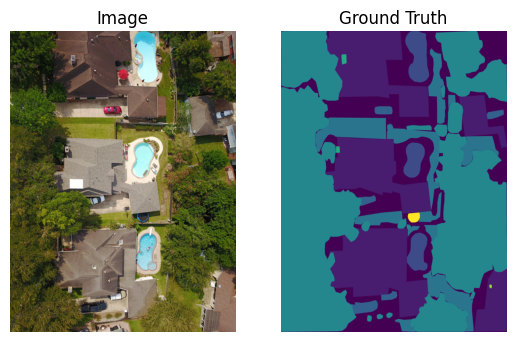

In [18]:
view_sample(train_dataset, 1)

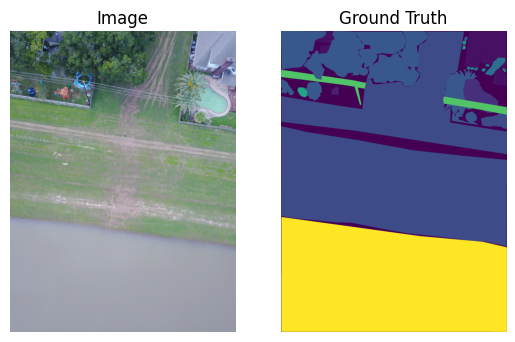

In [19]:
view_sample(val_dataset, 1)

## Setting up the model and parameters

In [20]:
# Similar functions to visualize the predictions of our model:

def denormalize_image(image, mean, std):
    """Denormalize the image."""
    return (
        image * torch.tensor(std)[:, None, None]
        + torch.tensor(mean)[:, None, None]
    )


def view_predictions(image, predictions, labels, axs=None):
    if axs is None:
        _, axs = plt.subplots(ncols=3)
    axs[0].imshow(
        denormalize_image(image, NORMALIZATION_MEANS, NORMALIZATION_STDS)
        .permute(1,2,0)
    )
    axs[0].axis('off')
    axs[0].set_title("Image")
    axs[1].imshow(predictions)
    axs[1].axis('off')
    axs[1].set_title("Prediction")
    axs[2].imshow(labels)
    axs[2].axis('off')
    axs[2].set_title("GT")
    return axs


def view_batch_prediction(model, images, labels):
    model.eval()
    with torch.no_grad():
        preds = model(images.to(DEVICE)).cpu()
        pred_labels = preds.argmax(1)

    n_images = images.shape[0]
    fig, axes = plt.subplots(
        nrows=n_images,
        ncols=3,
        figsize=(15, n_images * 5),
        constrained_layout=True,
    )

    for i, (image, pred_label, gt_label) in enumerate(
        zip(images, pred_labels, labels)
    ):
        view_predictions(image, pred_label, gt_label, axs=axes[i])

    plt.axis("off")
    plt.show()

In [21]:
TRAIN_BATCH_SIZE = 2
VAL_BATCH_SIZE = 2

N_CHANNELS = 3
N_CLASSES = 25

NORMALIZATION_MEANS = [0.4643, 0.3185, 0.3141]
NORMALIZATION_STDS = [0.2171, 0.1561, 0.1496]

In [22]:
model = UNet(in_channels=N_CHANNELS, n_classes=N_CLASSES).to(DEVICE)

In [23]:
transform = T.Compose(
    [
        T.CenterCrop(3000),
        T.Resize(512),
        T.ToTensor(),
        T.Normalize(mean=NORMALIZATION_MEANS, std=NORMALIZATION_STDS),
    ]
)

mask_transform = T.Compose(
    [
        T.CenterCrop(3000),
        T.Resize(512),
        np.asarray,
        torch.tensor,
    ]
)

train_dataset = SemanticSegmentationSatelliteImageryDataset(
    "./", train=True, transform=transform, mask_transform=mask_transform
)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True
)
validation_dataset = SemanticSegmentationSatelliteImageryDataset(
    "./", train=False, transform=transform, mask_transform=mask_transform
)
validation_loader = torch.utils.data.DataLoader(
    validation_dataset, batch_size=VAL_BATCH_SIZE, shuffle=True
)

In [24]:
# Extract the first validation batch for qualitative checks:

images, labels = next(iter(validation_loader))

In [25]:
len(images)

2

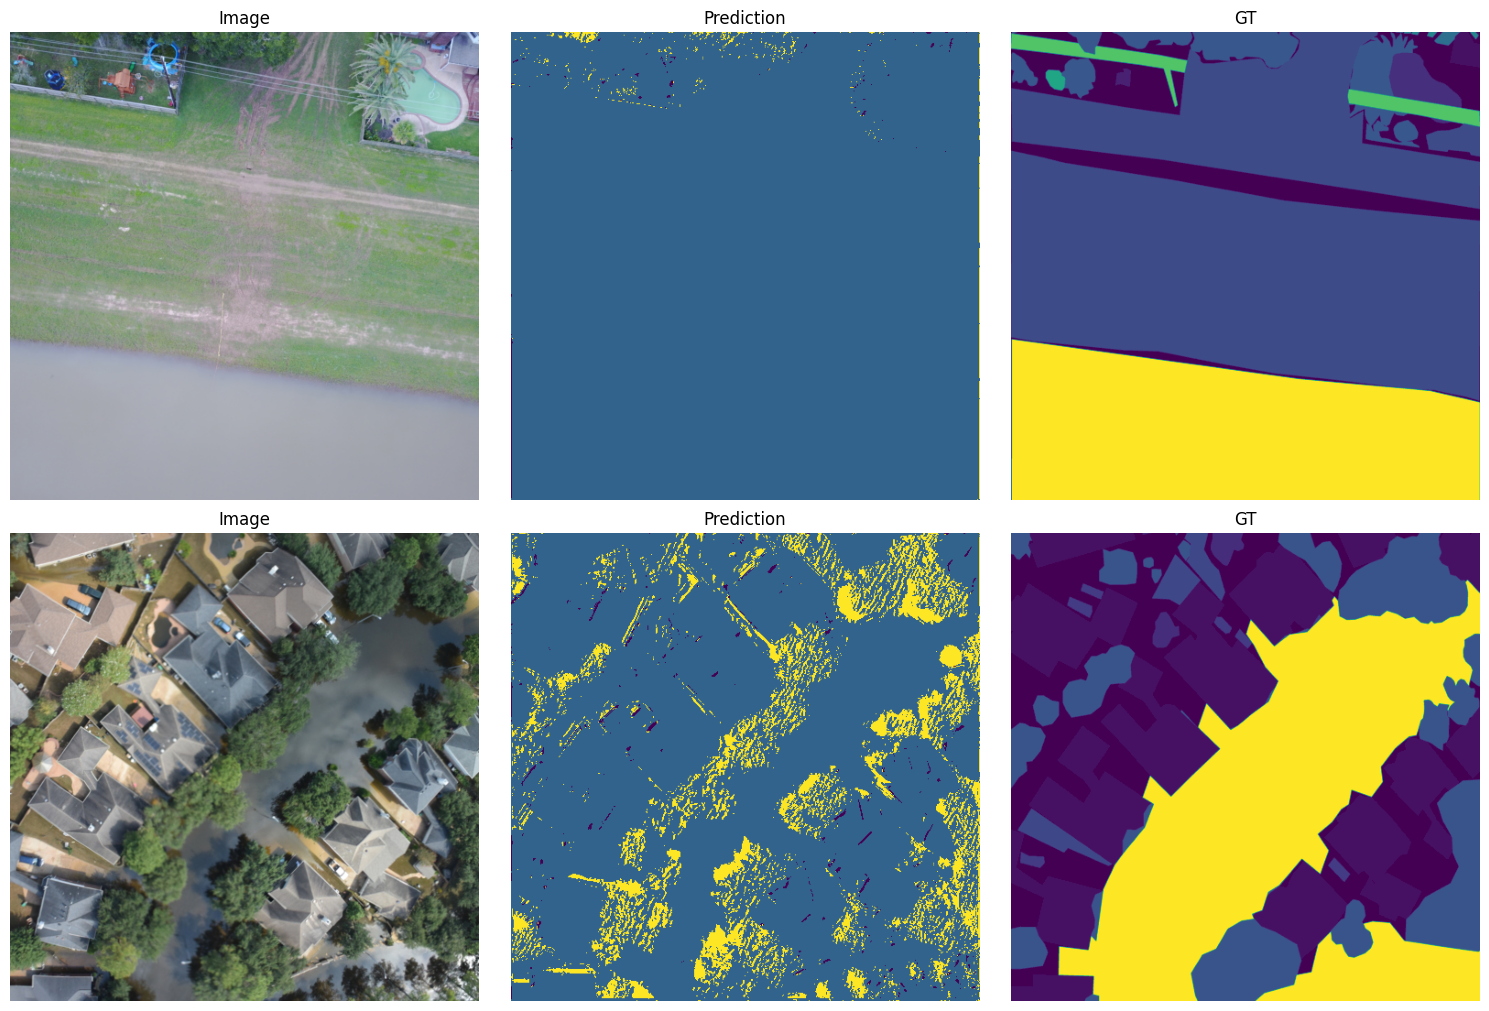

In [26]:
view_batch_prediction(model, images, labels)

## Exercise: The training loop

With the dataloader defined and the model initialized. Write the training loop to train the semantic segmentation model.

In [27]:
# Define an optimizer (e.g. Adam or SGD with momentum) for the unet and choose
# a loss function among the two defined above.
# Then, write the training loop to perform semantic segmentation.

# Use google to look for example usage on pytorch.org if you want remember how
# to setup a training loop and adapt it to train our segmentation model.
N_EPOCHS = 3  # Computation is costly, let's only do 3 passes over the data.
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-6

optimizer = ...  # TODO: update me!
loss_fn = ... # TODO: update me!


# TODO: write the training loop here!


# NOTE: You can compute validation metrics such as pixel accuracy on the
# validation set to monitor the training.
# ....  Other metrics might be more adapted to semantic segmentation such as
# the DICE index.



### Potential Solution

In [28]:
# Try other optimizers if you want !
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Here choose the loss function.
loss_fn = SemanticCrossEntropyLoss()
# loss_fn = SemanticFocalLoss(gamma=1)

losses = []
accs = []

# First evaluation of the randomly initialized model:
model.eval()

well_predicted = 0
total_predicted = 0

for images, labels in validation_loader:
    with torch.no_grad():
        preds = model(images.to(DEVICE))

    pred_labels = preds.argmax(dim=1)
    well_predicted += (labels.to(DEVICE) == pred_labels).sum()
    total_predicted += labels.numel()

val_acc = well_predicted / total_predicted
print(f"Validation Accuracy : {val_acc:2.3f}.")
accs.append(val_acc)


for epoch in range(N_EPOCHS):
    epoch_losses = []

    # Setting the model in train mode i.e. activates all training layers such
    # as batch normalization and dropout layers if any.
    model.train()

    # Just to have a nice loading bar.
    pbar = tqdm(train_loader, desc=f"Epoch {epoch} ")

    for images, labels in pbar:
        # Remember to send the data to the GPU (if you are using it !).
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        masks_pred = model(images)
        loss = loss_fn(masks_pred, labels)

        # You know the drill.
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss_value = loss.cpu().item()

        epoch_losses.append(loss_value)
        pbar.set_description(f"Epoch {epoch}, Loss : {loss_value:.2f} ")

    losses.append(epoch_losses)

    # Validations step.
    model.eval()

    well_predicted = 0
    total_predicted = 0

    for images, labels in validation_loader:
        with torch.no_grad():
            preds = model(images.to(DEVICE))

        pred_labels = preds.argmax(dim=1)
        well_predicted += (labels.to(DEVICE) == pred_labels).sum()
        total_predicted += labels.numel()

    val_acc = well_predicted / total_predicted
    print(f"Validation Accuracy : {val_acc:2.3f}.")
    accs.append(val_acc)

    torch.save(
        model.state_dict(),
        f"semantic_segmentation_si_unet_epoch_{epoch:03d}.model"
    )

Validation Accuracy : 0.025.


Epoch 0 :   0%|          | 0/107 [00:00<?, ?it/s]

Validation Accuracy : 0.533.


Epoch 1 :   0%|          | 0/107 [00:00<?, ?it/s]

Validation Accuracy : 0.520.


Epoch 2 :   0%|          | 0/107 [00:00<?, ?it/s]

Validation Accuracy : 0.561.


You don't know what is the focal loss ? [Here](https://arxiv.org/abs/1708.02002) is the paper !

We can save the parameters of the model for later use.

In [29]:
# Here you can save the model for further use.
save_path = "semantic_segmentation_si_unet.model"
torch.save(model.state_dict(), save_path)

We can also download and apply the weights to a pretrained model trained for 20 epochs which reaches ~60% accuracy on the validation set.

In [30]:
pretrained_model_path = "pretrained_semantic_segmentation_si_unet.model"
download_url_to_file(
    "https://www.dropbox.com/scl/fi/rtfn746yx540hsz8zbljl/semantic_segmentation_si_unet.model?rlkey=a9xoamt2m5mhp6xzklg7dxlad&dl=1", dst=pretrained_model_path
)

100%|██████████| 118M/118M [00:05<00:00, 21.1MB/s]


Look at the results with your model first (by skipping the next cell). Then come to uncomment the loading of the pretrained weights to see the difference.

In [31]:
# model.load_state_dict(torch.load(pretrained_model_path, weights_only=True))

## Let's see the results !

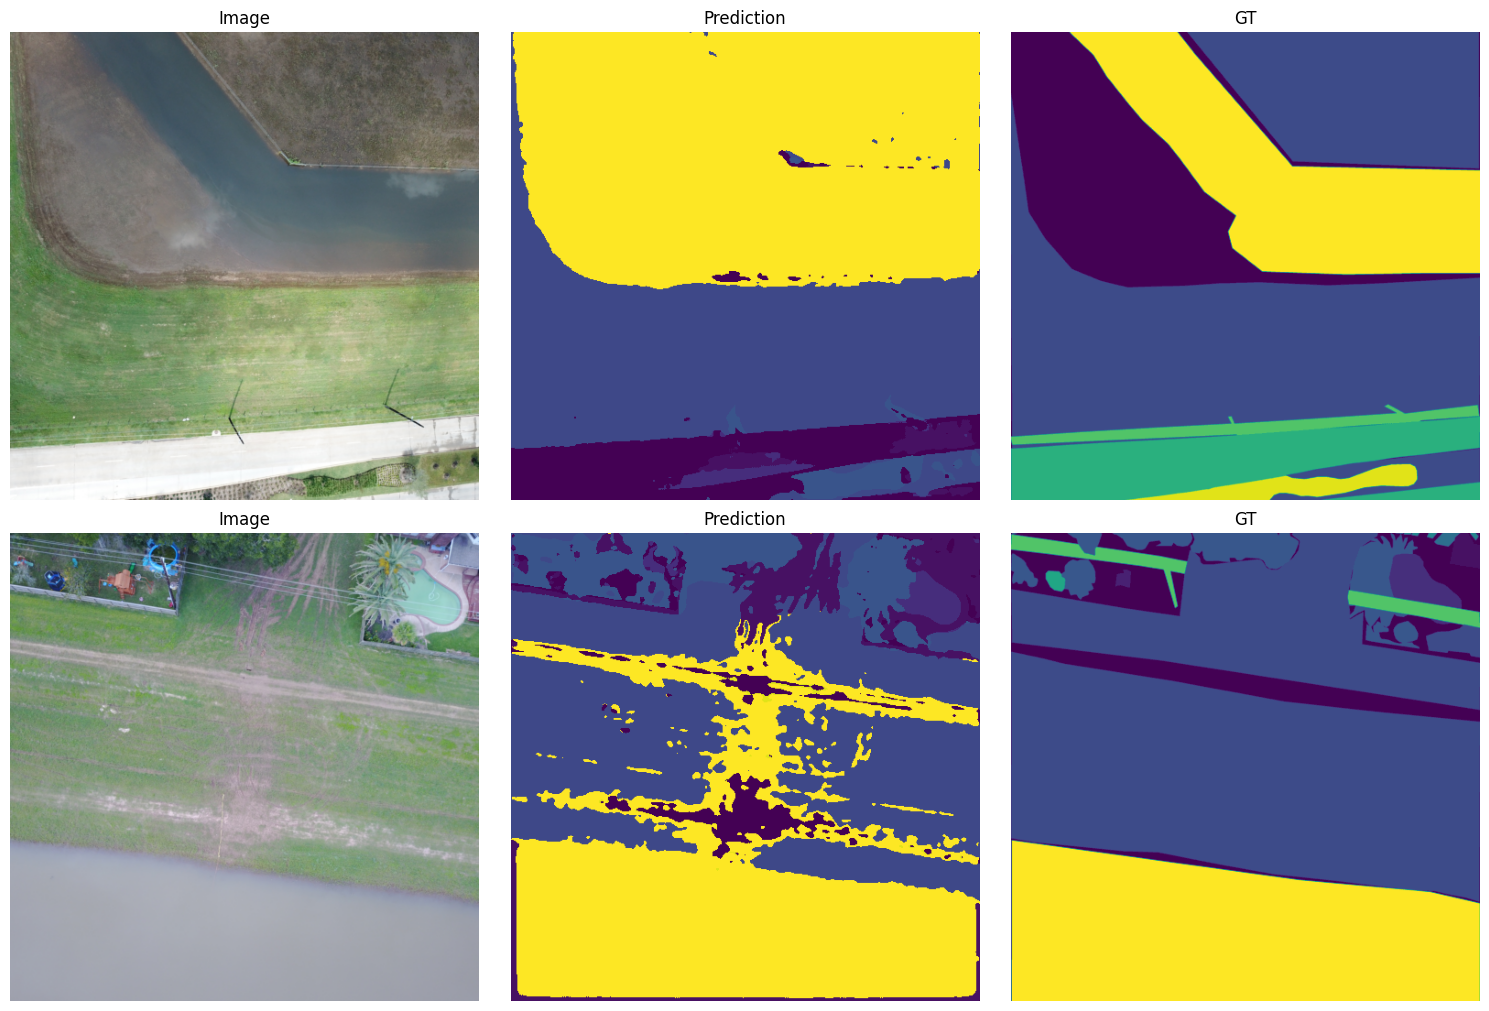

In [32]:
# And now let's see it !

images, labels = next(iter(validation_loader))

view_batch_prediction(model, images, labels)